# Beginners Guide to Text Generation using LSTMs

Text Generation is a type of Language Modelling problem. Language Modelling is the core problem for a number of of natural language processing tasks such as speech to text, conversational system, and text summarization. A trained language model learns the likelihood of occurrence of a word based on the previous sequence of words used in the text. Language models can be operated at character level, n-gram level, sentence level or even paragraph level. In this notebook, I will explain how to create a language model for generating natural language text by implement and training state-of-the-art Recurrent Neural Network. 

### Generating News headlines 

In this kernel, I will be using the dataset of [New York Times Comments and Headlines](https://www.kaggle.com/aashita/nyt-comments) to train a text generation language model which can be used to generate News Headlines


## 1. Import the libraries

As the first step, we need to import the required libraries:

In [1]:
# keras module for building LSTM 
import tensorflow as tf
from tensorflow.keras.utils import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
import tensorflow.keras.utils as ku 


import pandas as pd
import numpy as np
import string, os 

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

## 2. Load the dataset

Load the dataset of news headlines

In [3]:
data = pd.read_csv("./dataset/inspiration.csv", index_col = 0)
data
data["all_text"] = data["Category"].astype(str) +" "+ data["Quote"]
new_data = data["all_text"]
all_headlines = new_data.tolist()

<function matplotlib.pyplot.show(close=None, block=None)>

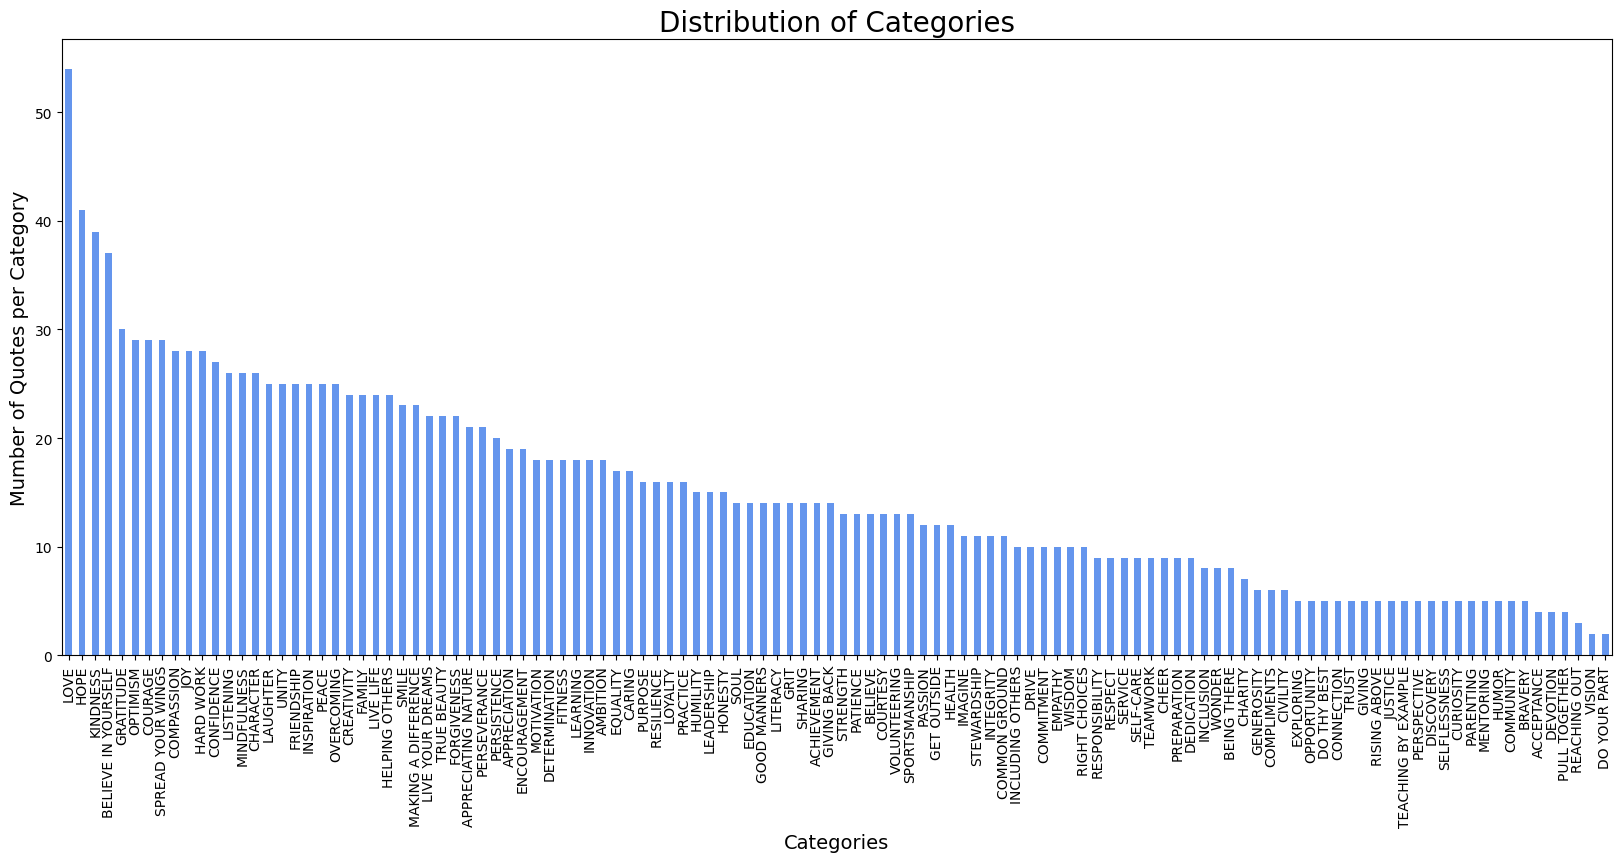

In [5]:
import matplotlib.pyplot as plt
data["Category"].value_counts().plot.bar(figsize=(20,8), color='cornflowerblue')
plt.title('Distribution of Categories', fontsize=20)
plt.xlabel('Categories', fontsize=14)
plt.ylabel('Mumber of Quotes per Category', fontsize=14)
plt.show

## 3. Dataset preparation

### 3.1 Dataset cleaning 

In dataset preparation step, we will first perform text cleaning of the data which includes removal of punctuations and lower casing all the words. 

In [7]:
def clean_text(txt):
    txt = "".join(v for v in txt).lower()
    txt = txt.encode("utf8").decode("ascii",'ignore')
    return txt 

corpus = [clean_text(x) for x in all_headlines]
corpus[:10]

['love let us see what love can do. ',
 'love we cant heal the world today. but we can begin with a voice of compassion, a heart of love, and an act of kindness. ',
 'listening listen with curiosity. speak with honesty. act with integrity. ',
 'listening the most basic and powerful way to connect to another person is to listen. just listen. ',
 'listening knowledge speaks, but wisdom listens. ',
 'listening deep listening is the kind of listening that can help relieve the suffering of another person. ',
 'listening every person in this life has something to teachand as soon as you accept that, you open yourself to truly listening. ',
 'stewardship there are no problems we cannot solve together, and very few that we can solve by ourselves. ',
 'stewardship i always wondered why somebody didnt do something about that; then i realized that i am somebody. ',
 'stewardship let us develop respect for all living things. let us try to replace violence and intolerance with understanding, compas

### 3.2 Generating Sequence of N-gram Tokens

Language modelling requires a sequence input data, as given a sequence (of words/tokens) the aim is the predict next word/token.  

The next step is Tokenization. Tokenization is a process of extracting tokens (terms / words) from a corpus. Python’s library Keras has inbuilt model for tokenization which can be used to obtain the tokens and their index in the corpus. After this step, every text document in the dataset is converted into sequence of tokens. 


In [8]:
tokenizer = Tokenizer(filters='!"#$%&()*+-/:;<=>@[\\]^_`{|}~\t\n',)

def get_sequence_of_tokens(corpus):
    ## tokenization
    new_corpus = []
    for x in corpus:
      to_tokenize = ['.',',',':',';','!','?']
      end_tokenize = [' .',' ,',' :',' ;',' !',' ?']
      for i, v in enumerate(to_tokenize):
        x = x.replace(v, end_tokenize[i])
      new_corpus.append(x)
    corpus = new_corpus
    tokenizer.fit_on_texts(corpus)
    total_words = len(tokenizer.word_index) + 1
    
    ## convert data to sequence of tokens 
    input_sequences = []
    for line in corpus:
        token_list = tokenizer.texts_to_sequences([line])[0]
        for i in range(1, len(token_list)):
            n_gram_sequence = token_list[:i+1]
            input_sequences.append(n_gram_sequence)
    return input_sequences, total_words

inp_sequences, total_words = get_sequence_of_tokens(corpus)
inp_sequences[:10]

AttributeError: 'list' object has no attribute 'plot'

In the above output [30, 507], [30, 507, 11], [30, 507, 11, 1] and so on represents the ngram phrases generated from the input data. where every integer corresponds to the index of a particular word in the complete vocabulary of words present in the text. For example

**Headline:** i stand  with the shedevils  
**Ngrams:** | **Sequence of Tokens**

<table>
<tr><td>Ngram </td><td> Sequence of Tokens</td></tr>
<tr> <td>i stand </td><td> [30, 507] </td></tr>
<tr> <td>i stand with </td><td> [30, 507, 11] </td></tr>
<tr> <td>i stand with the </td><td> [30, 507, 11, 1] </td></tr>
<tr> <td>i stand with the shedevils </td><td> [30, 507, 11, 1, 975] </td></tr>
</table>



### 3.3 Padding the Sequences and obtain Variables : Predictors and Target

Now that we have generated a data-set which contains sequence of tokens, it is possible that different sequences have different lengths. Before starting training the model, we need to pad the sequences and make their lengths equal. We can use pad_sequence function of Kears for this purpose. To input this data into a learning model, we need to create predictors and label. We will create N-grams sequence as predictors and the next word of the N-gram as label. For example:


Headline:  they are learning data science

<table>
<tr><td>PREDICTORS </td> <td>           LABEL </td></tr>
<tr><td>they                   </td> <td>  are</td></tr>
<tr><td>they are               </td> <td>  learning</td></tr>
<tr><td>they are learning      </td> <td>  data</td></tr>
<tr><td>they are learning data </td> <td>  science</td></tr>
</table>

In [5]:
def generate_padded_sequences(input_sequences):
    max_sequence_len = max([len(x) for x in input_sequences])
    input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))
    
    predictors, label = input_sequences[:,:-1],input_sequences[:,-1]
    label = ku.to_categorical(label, num_classes=total_words)
    return predictors, label, max_sequence_len

predictors, label, max_sequence_len = generate_padded_sequences(inp_sequences)

Perfect, now we can obtain the input vector X and the label vector Y which can be used for the training purposes. Recent experiments have shown that recurrent neural networks have shown a good performance in sequence to sequence learning and text data applications. Lets look at them in brief.

## 4. LSTMs for Text Generation

![](http://www.shivambansal.com/blog/text-lstm/2.png)

Unlike Feed-forward neural networks in which activation outputs are propagated only in one direction, the activation outputs from neurons propagate in both directions (from inputs to outputs and from outputs to inputs) in Recurrent Neural Networks. This creates loops in the neural network architecture which acts as a ‘memory state’ of the neurons. This state allows the neurons an ability to remember what have been learned so far.

The memory state in RNNs gives an advantage over traditional neural networks but a problem called Vanishing Gradient is associated with them. In this problem, while learning with a large number of layers, it becomes really hard for the network to learn and tune the parameters of the earlier layers. To address this problem, A new type of RNNs called LSTMs (Long Short Term Memory) Models have been developed.

LSTMs have an additional state called ‘cell state’ through which the network makes adjustments in the information flow. The advantage of this state is that the model can remember or forget the leanings more selectively. To learn more about LSTMs, here is a great post. Lets architecture a LSTM model in our code. I have added total three layers in the model.

1. Input Layer : Takes the sequence of words as input
2. LSTM Layer : Computes the output using LSTM units. I have added 100 units in the layer, but this number can be fine tuned later.
3. Dropout Layer : A regularisation layer which randomly turns-off the activations of some neurons in the LSTM layer. It helps in preventing over fitting. (Optional Layer)
4. Output Layer : Computes the probability of the best possible next word as output

We will run this model for total 100 epoochs but it can be experimented further.

In [6]:
def create_model(max_sequence_len, total_words):
    input_len = max_sequence_len - 1
    model = tf.keras.models.Sequential()
    
    # Add Input Embedding Layer
    model.add(tf.keras.layers.Embedding(total_words, 512, input_length=input_len))
    
    # Add Hidden Layer 1 - LSTM Layer
    model.add(tf.keras.layers.GRU(512))
    model.add(tf.keras.layers.Dropout(0.5))
    
    # Add Output Layer
    model.add(Dense(total_words, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

model = create_model(max_sequence_len, total_words)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 136, 512)          1911808   
                                                                 
 gru (GRU)                   (None, 512)               1575936   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 3734)              1915542   
                                                                 
Total params: 5,403,286
Trainable params: 5,403,286
Non-trainable params: 0
_________________________________________________________________


Lets train our model now

In [8]:
callback = [EarlyStopping(monitor='loss', patience=5)]
model.fit(predictors, label, epochs=35, callbacks=[callback], shuffle=False)

Epoch 1/35
1273/1273 [==============================] - 53s 37ms/step - loss: 5.6852 - accuracy: 0.1224
Epoch 2/35
1273/1273 [==============================] - 30s 23ms/step - loss: 4.9585 - accuracy: 0.1763
Epoch 3/35
1273/1273 [==============================] - 29s 23ms/step - loss: 4.4597 - accuracy: 0.2155
Epoch 4/35
1273/1273 [==============================] - 30s 23ms/step - loss: 3.9254 - accuracy: 0.2624
Epoch 5/35
1273/1273 [==============================] - 29s 23ms/step - loss: 3.3738 - accuracy: 0.3167
Epoch 6/35
1273/1273 [==============================] - 29s 22ms/step - loss: 2.8725 - accuracy: 0.3786
Epoch 7/35
1273/1273 [==============================] - 28s 22ms/step - loss: 2.4248 - accuracy: 0.4487
Epoch 8/35
1273/1273 [==============================] - 28s 22ms/step - loss: 2.0903 - accuracy: 0.5093
Epoch 9/35
1273/1273 [==============================] - 28s 22ms/step - loss: 1.8383 - accuracy: 0.5508
Epoch 10/35
1273/1273 [==============================] - 28s 22m

## 5. Generating the text 

Great, our model architecture is now ready and we can train it using our data. Next lets write the function to predict the next word based on the input words (or seed text). We will first tokenize the seed text, pad the sequences and pass into the trained model to get predicted word. The multiple predicted words can be appended together to get predicted sequence.


In [9]:
def generate_text(seed_text, model, max_sequence_len):
    output_word = ""
    while output_word != "." and output_word != "!" and output_word != "?":
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
        predict_x=model.predict(token_list,verbose=0) 
        predicted=np.argmax(predict_x, axis=1)
        
        output_word = ""
        for word,index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break
        seed_text += " "+output_word
    return seed_text.title()

In [10]:
print (generate_text("Is it okay to feel sad?", model, max_sequence_len))
print (generate_text("What is my life's purpose?", model, max_sequence_len))
print (generate_text("What's the meaning of life?", model, max_sequence_len))
print (generate_text("Purpose", model, max_sequence_len))
print (generate_text("Love", model, max_sequence_len))
print (generate_text("Grit", model, max_sequence_len))
print (generate_text("Sadness", model, max_sequence_len))
print (generate_text("Suicide", model, max_sequence_len))
print (generate_text("Why live?", model, max_sequence_len))

Is It Okay To Feel Sad? The World Who Will Be An Idea .
What Is My Life'S Purpose? Way , I Have No Interest To Do It .
What'S The Meaning Of Life? Life .
Purpose The Purpose Of Life Is To Be Happy .
Love We Have To Stand Up For Something , We Call It A Thief .
Grit The Ultimate Measure Of A Man Is Not Where He Stands At Times Of Challenge And Controversy .
Sadness You Can'T Do Great Things , You Can Do Better Than The World To Do .
Suicide We Have To Stand Up For Those Who Believe In The World Is Made Of Faith .
Why Live? I Think You Can Accomplish Anything , Absolutely Anything If You Can Do .


## Improvement Ideas 

As we can see, the model has produced the output which looks fairly fine. The results can be improved further with following points:
- Adding more data
- Fine Tuning the network architecture
- Fine Tuning the network parameters

Thanks for going through the notebook, please upvote if you liked. 